# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

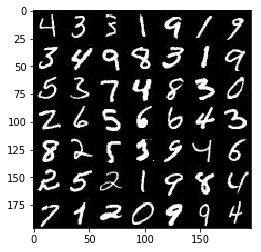

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

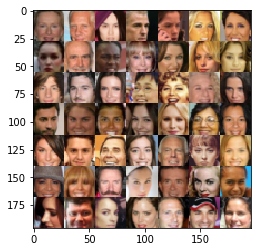

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), 
                                 name='input_image')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # input image is 28x28x3 for celeb1 and 28x28x1 for mnist
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, kernel_size=4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              activation=None)
        x1 = tf.layers.dropout(x1, rate=0.5)
        x1 = tf.nn.leaky_relu(x1)
        # not using batchnorm in this layer as suggested by DCGAN paper
        # now is 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size=4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, rate=0.5)
        x2 = tf.nn.leaky_relu(x2)
        # now is 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size=4, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.layers.dropout(x3, rate=0.5)
        x3 = tf.nn.leaky_relu(x3)
        # now is 4x4x256
        
        flattened = tf.reshape(x3, (-1,4*4*256))
        
        d_logits = tf.layers.dense(flattened, 1, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        d_out = tf.sigmoid(d_logits)

    return d_out, d_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train:
        reuse = False 
    else:
        reuse = True # need to reuse the variables to generate new samples
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 3*3*512, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                             activation=tf.nn.leaky_relu)
        x1 = tf.reshape(x1, (-1,3,3,512))
        # now 3x3x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=4, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                        activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2)
        # now 6x6x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=4, strides=2, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                        activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3)
        # now 14x14x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, kernel_size=4, strides=1, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                        activation=None)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.leaky_relu(x4)
        # now 14x14x64
        
        
        x5 = tf.layers.conv2d_transpose(x4, out_channel_dim, kernel_size=4, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                        activation=None)
        g_out = tf.nn.tanh(x5)
        # now is 28x28xout_channel_dim
        
    return g_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # label smoothing
    smooth = 0.1
    
    # generator and discriminator outputs
    g_out = generator(input_z, out_channel_dim, is_train=True) # g_out shape is 28x28xout_channel_dim
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    # labels
    d_labels_real = tf.ones_like(d_out_real) * (1.0 - smooth)
    d_labels_fake = tf.zeros_like(d_out_fake)
    g_labels = tf.ones_like(d_out_fake)
    
    # losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake # discriminator loss is sum of real and fake losses
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get all trainable variables, split them in G and D variables
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # create optimizer ops for both generator and discriminator
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [27]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
print(mnist_dataset.image_mode)

(60000, 28, 28, 1)
L


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    image_channels = data_shape[3]
    input_real, input_z, lr_tensor = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run both optimizers
                _ = sess.run(d_train_op, 
                             feed_dict={input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_op, 
                             feed_dict={input_z: batch_z, input_real: batch_images, lr_tensor: learning_rate})
                
                if steps%50 == 0:
                    train_loss_d = sess.run(d_loss,
                        feed_dict={input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z, lr_tensor: learning_rate})
                    
                    print("Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps%200 == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                    
#         saver.save(sess, './checkpoints/generator.ckpt')
        
    return losses        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 50... Discriminator Loss: 1.5849... Generator Loss: 0.3647
Step 100... Discriminator Loss: 1.5558... Generator Loss: 0.5295
Step 150... Discriminator Loss: 1.1713... Generator Loss: 1.5385
Step 200... Discriminator Loss: 1.4399... Generator Loss: 0.5021


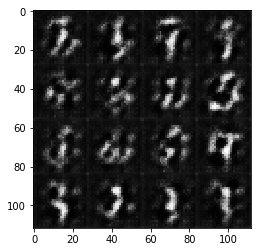

Step 250... Discriminator Loss: 1.5633... Generator Loss: 0.4759
Step 300... Discriminator Loss: 1.4449... Generator Loss: 1.6905
Step 350... Discriminator Loss: 1.5177... Generator Loss: 0.4025
Step 400... Discriminator Loss: 1.1781... Generator Loss: 0.6489


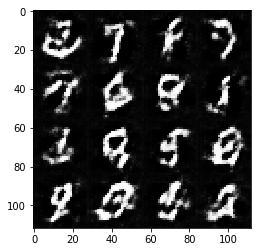

Step 450... Discriminator Loss: 1.0920... Generator Loss: 0.7342
Step 500... Discriminator Loss: 1.7793... Generator Loss: 0.3255
Step 550... Discriminator Loss: 1.1280... Generator Loss: 2.3132
Step 600... Discriminator Loss: 1.1320... Generator Loss: 0.9552


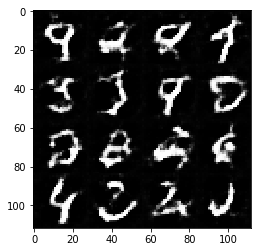

Step 650... Discriminator Loss: 1.1725... Generator Loss: 1.4642
Step 700... Discriminator Loss: 1.7428... Generator Loss: 0.2905
Step 750... Discriminator Loss: 1.1101... Generator Loss: 0.7851
Step 800... Discriminator Loss: 0.9509... Generator Loss: 1.0457


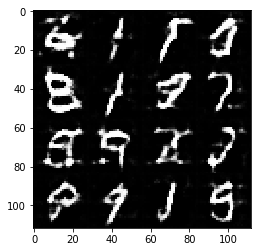

Step 850... Discriminator Loss: 1.2261... Generator Loss: 0.5952
Step 900... Discriminator Loss: 1.3515... Generator Loss: 0.5509
Step 950... Discriminator Loss: 1.1079... Generator Loss: 1.8331
Step 1000... Discriminator Loss: 0.8851... Generator Loss: 1.5163


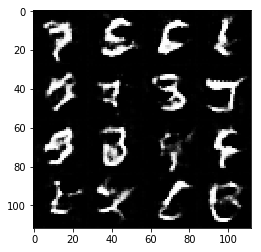

Step 1050... Discriminator Loss: 1.4032... Generator Loss: 0.4717
Step 1100... Discriminator Loss: 2.3625... Generator Loss: 0.2322
Step 1150... Discriminator Loss: 0.7557... Generator Loss: 2.0080
Step 1200... Discriminator Loss: 1.1053... Generator Loss: 1.5459


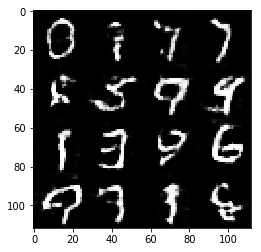

Step 1250... Discriminator Loss: 1.1880... Generator Loss: 0.6589
Step 1300... Discriminator Loss: 0.9510... Generator Loss: 0.9032
Step 1350... Discriminator Loss: 1.8293... Generator Loss: 0.3155
Step 1400... Discriminator Loss: 1.2516... Generator Loss: 0.7391


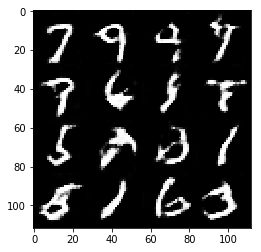

Step 1450... Discriminator Loss: 0.8842... Generator Loss: 1.0930
Step 1500... Discriminator Loss: 0.8312... Generator Loss: 1.2179
Step 1550... Discriminator Loss: 1.0701... Generator Loss: 0.8165
Step 1600... Discriminator Loss: 0.9874... Generator Loss: 0.9645


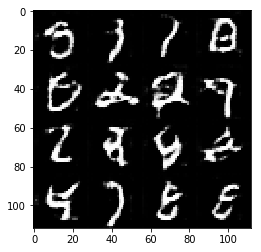

Step 1650... Discriminator Loss: 0.8421... Generator Loss: 1.8632
Step 1700... Discriminator Loss: 1.2106... Generator Loss: 0.7979
Step 1750... Discriminator Loss: 0.9573... Generator Loss: 0.8542
Step 1800... Discriminator Loss: 0.9421... Generator Loss: 0.8772


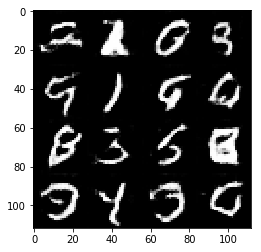

Step 1850... Discriminator Loss: 1.0557... Generator Loss: 0.7164
Step 1900... Discriminator Loss: 1.0189... Generator Loss: 0.9092
Step 1950... Discriminator Loss: 0.9355... Generator Loss: 0.9244
Step 2000... Discriminator Loss: 0.8731... Generator Loss: 1.0249


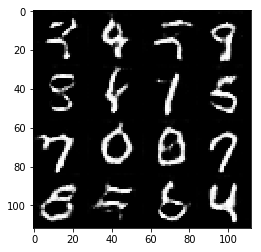

Step 2050... Discriminator Loss: 0.8074... Generator Loss: 1.6603
Step 2100... Discriminator Loss: 0.8950... Generator Loss: 1.0005
Step 2150... Discriminator Loss: 1.7423... Generator Loss: 0.4355
Step 2200... Discriminator Loss: 0.7763... Generator Loss: 1.2103


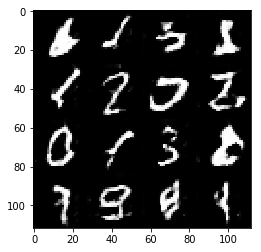

Step 2250... Discriminator Loss: 0.6919... Generator Loss: 1.6575
Step 2300... Discriminator Loss: 0.8223... Generator Loss: 1.1102
Step 2350... Discriminator Loss: 0.6924... Generator Loss: 1.5412
Step 2400... Discriminator Loss: 1.0625... Generator Loss: 0.7723


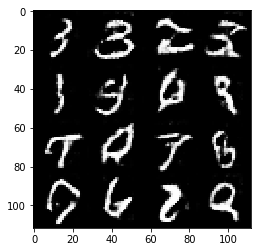

Step 2450... Discriminator Loss: 0.8494... Generator Loss: 1.2346
Step 2500... Discriminator Loss: 0.9259... Generator Loss: 1.0374
Step 2550... Discriminator Loss: 0.7135... Generator Loss: 2.4476
Step 2600... Discriminator Loss: 0.8296... Generator Loss: 1.8711


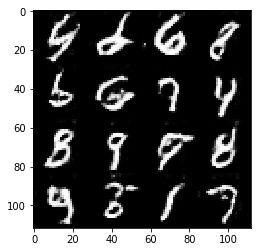

Step 2650... Discriminator Loss: 0.7252... Generator Loss: 1.6697
Step 2700... Discriminator Loss: 1.1014... Generator Loss: 0.7582
Step 2750... Discriminator Loss: 1.5380... Generator Loss: 0.4443
Step 2800... Discriminator Loss: 0.9363... Generator Loss: 0.8789


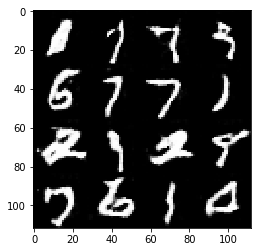

Step 2850... Discriminator Loss: 0.6688... Generator Loss: 1.4509
Step 2900... Discriminator Loss: 0.7987... Generator Loss: 1.3901
Step 2950... Discriminator Loss: 0.8868... Generator Loss: 1.0162
Step 3000... Discriminator Loss: 0.9804... Generator Loss: 0.8397


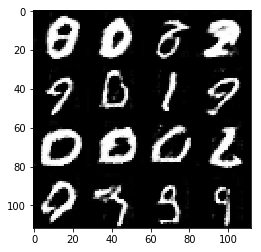

Step 3050... Discriminator Loss: 0.5214... Generator Loss: 2.0640
Step 3100... Discriminator Loss: 1.2162... Generator Loss: 0.5978
Step 3150... Discriminator Loss: 0.5358... Generator Loss: 1.8969
Step 3200... Discriminator Loss: 0.6960... Generator Loss: 1.3693


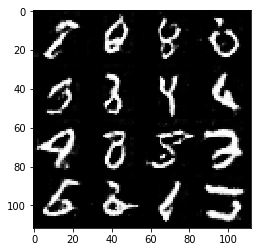

Step 3250... Discriminator Loss: 0.6980... Generator Loss: 1.5372
Step 3300... Discriminator Loss: 0.6484... Generator Loss: 2.4259
Step 3350... Discriminator Loss: 1.0010... Generator Loss: 0.8773
Step 3400... Discriminator Loss: 1.0494... Generator Loss: 0.8985


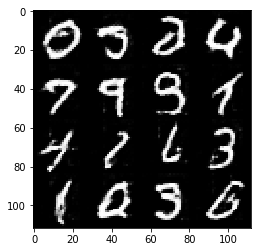

Step 3450... Discriminator Loss: 0.9791... Generator Loss: 0.8461
Step 3500... Discriminator Loss: 1.1451... Generator Loss: 0.7141
Step 3550... Discriminator Loss: 0.9050... Generator Loss: 1.1706
Step 3600... Discriminator Loss: 1.2524... Generator Loss: 0.6502


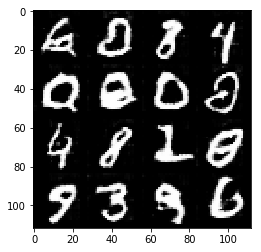

Step 3650... Discriminator Loss: 0.6919... Generator Loss: 2.5854
Step 3700... Discriminator Loss: 0.7762... Generator Loss: 1.2531
Step 3750... Discriminator Loss: 1.0649... Generator Loss: 0.8449
Step 3800... Discriminator Loss: 0.6462... Generator Loss: 1.7445


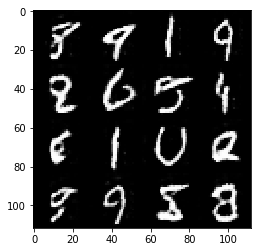

Step 3850... Discriminator Loss: 0.9000... Generator Loss: 1.0270
Step 3900... Discriminator Loss: 1.1125... Generator Loss: 0.8682
Step 3950... Discriminator Loss: 0.5523... Generator Loss: 2.0060
Step 4000... Discriminator Loss: 0.6198... Generator Loss: 1.9302


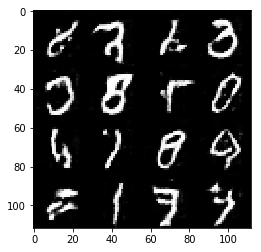

Step 4050... Discriminator Loss: 0.7729... Generator Loss: 1.1989
Step 4100... Discriminator Loss: 0.6685... Generator Loss: 1.4407
Step 4150... Discriminator Loss: 0.5976... Generator Loss: 1.8427
Step 4200... Discriminator Loss: 0.6415... Generator Loss: 1.7165


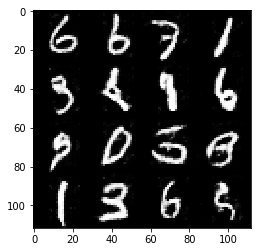

Step 4250... Discriminator Loss: 0.9093... Generator Loss: 0.9457
Step 4300... Discriminator Loss: 1.1140... Generator Loss: 0.8326
Step 4350... Discriminator Loss: 1.2666... Generator Loss: 0.6402
Step 4400... Discriminator Loss: 0.6975... Generator Loss: 1.5599


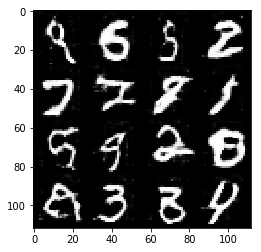

Step 4450... Discriminator Loss: 0.8887... Generator Loss: 1.0821
Step 4500... Discriminator Loss: 1.0876... Generator Loss: 0.7821
Step 4550... Discriminator Loss: 0.7091... Generator Loss: 1.6024
Step 4600... Discriminator Loss: 2.2684... Generator Loss: 4.1160


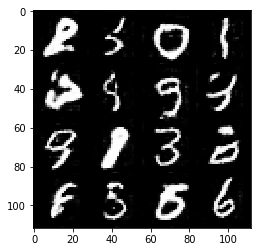

Step 4650... Discriminator Loss: 0.7923... Generator Loss: 1.2067
Step 4700... Discriminator Loss: 0.6051... Generator Loss: 1.9914
Step 4750... Discriminator Loss: 1.5720... Generator Loss: 0.4169
Step 4800... Discriminator Loss: 0.7112... Generator Loss: 1.6269


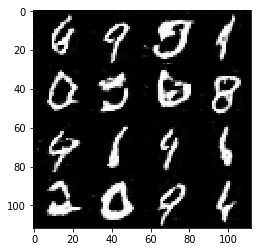

Step 4850... Discriminator Loss: 1.1494... Generator Loss: 0.7040
Step 4900... Discriminator Loss: 0.7171... Generator Loss: 1.3511
Step 4950... Discriminator Loss: 0.7542... Generator Loss: 1.3455
Step 5000... Discriminator Loss: 0.6295... Generator Loss: 1.5283


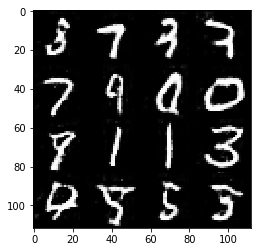

Step 5050... Discriminator Loss: 1.3032... Generator Loss: 0.5654
Step 5100... Discriminator Loss: 0.9590... Generator Loss: 0.8769
Step 5150... Discriminator Loss: 1.1335... Generator Loss: 0.6876
Step 5200... Discriminator Loss: 1.0360... Generator Loss: 0.7557


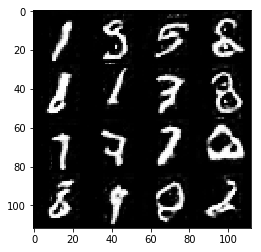

Step 5250... Discriminator Loss: 0.6197... Generator Loss: 2.0367
Step 5300... Discriminator Loss: 1.1237... Generator Loss: 2.6007
Step 5350... Discriminator Loss: 0.8361... Generator Loss: 1.0243
Step 5400... Discriminator Loss: 0.5023... Generator Loss: 2.0661


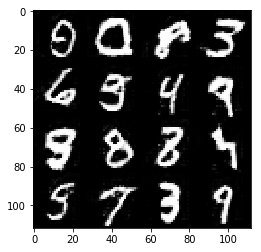

Step 5450... Discriminator Loss: 0.8569... Generator Loss: 1.0210
Step 5500... Discriminator Loss: 0.6513... Generator Loss: 1.5840
Step 5550... Discriminator Loss: 0.6646... Generator Loss: 1.5194
Step 5600... Discriminator Loss: 0.8424... Generator Loss: 1.1358


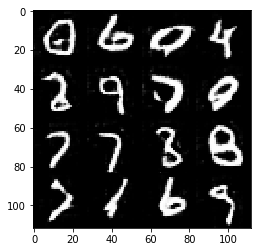

Step 5650... Discriminator Loss: 1.3391... Generator Loss: 0.5635
Step 5700... Discriminator Loss: 0.7512... Generator Loss: 1.1520
Step 5750... Discriminator Loss: 1.2704... Generator Loss: 2.3696
Step 5800... Discriminator Loss: 0.9037... Generator Loss: 1.1351


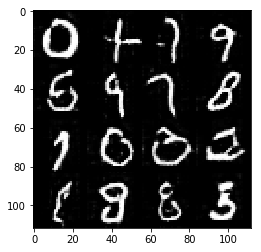

Step 5850... Discriminator Loss: 0.5889... Generator Loss: 1.9508
Step 5900... Discriminator Loss: 0.6897... Generator Loss: 1.5829
Step 5950... Discriminator Loss: 0.5943... Generator Loss: 1.6466
Step 6000... Discriminator Loss: 0.6884... Generator Loss: 1.3993


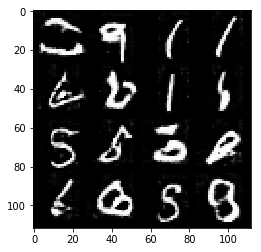

Step 6050... Discriminator Loss: 0.7080... Generator Loss: 1.9692
Step 6100... Discriminator Loss: 0.9666... Generator Loss: 1.0646
Step 6150... Discriminator Loss: 1.8412... Generator Loss: 0.3294
Step 6200... Discriminator Loss: 0.6720... Generator Loss: 1.4451


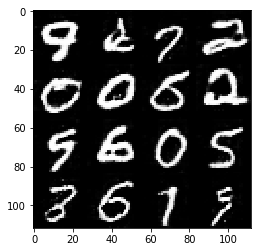

Step 6250... Discriminator Loss: 0.8942... Generator Loss: 0.9828
Step 6300... Discriminator Loss: 0.7720... Generator Loss: 1.2884
Step 6350... Discriminator Loss: 1.2118... Generator Loss: 0.6717
Step 6400... Discriminator Loss: 0.9041... Generator Loss: 0.9236


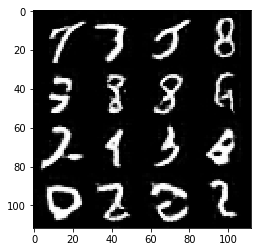

Step 6450... Discriminator Loss: 1.3720... Generator Loss: 0.6240
Step 6500... Discriminator Loss: 1.1362... Generator Loss: 0.8228
Step 6550... Discriminator Loss: 0.9908... Generator Loss: 0.8517
Step 6600... Discriminator Loss: 0.5493... Generator Loss: 1.7985


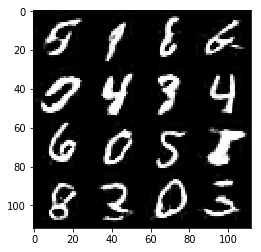

Step 6650... Discriminator Loss: 0.7579... Generator Loss: 1.5950
Step 6700... Discriminator Loss: 0.9898... Generator Loss: 1.9650
Step 6750... Discriminator Loss: 0.6080... Generator Loss: 1.9610
Step 6800... Discriminator Loss: 0.7395... Generator Loss: 1.2642


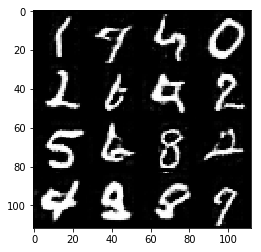

Step 6850... Discriminator Loss: 1.1001... Generator Loss: 0.7602
Step 6900... Discriminator Loss: 0.6310... Generator Loss: 1.6365
Step 6950... Discriminator Loss: 0.5300... Generator Loss: 1.9205
Step 7000... Discriminator Loss: 0.8238... Generator Loss: 1.1570


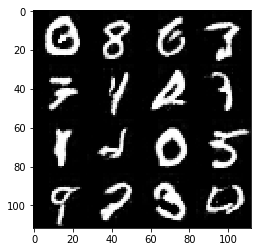

Step 7050... Discriminator Loss: 0.8270... Generator Loss: 1.2289
Step 7100... Discriminator Loss: 0.9560... Generator Loss: 1.0722
Step 7150... Discriminator Loss: 1.0885... Generator Loss: 0.7277
Step 7200... Discriminator Loss: 0.9827... Generator Loss: 0.9331


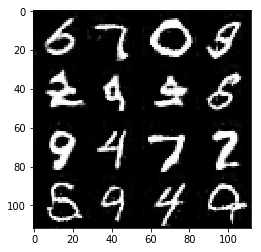

Step 7250... Discriminator Loss: 0.7314... Generator Loss: 1.2926
Step 7300... Discriminator Loss: 1.2186... Generator Loss: 0.6569
Step 7350... Discriminator Loss: 1.2870... Generator Loss: 0.5984
Step 7400... Discriminator Loss: 0.6578... Generator Loss: 1.4508


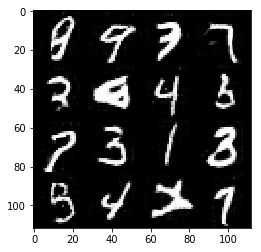

Step 7450... Discriminator Loss: 0.6773... Generator Loss: 1.3768
Step 7500... Discriminator Loss: 1.1030... Generator Loss: 0.7191


In [16]:
# with smooth = 0.1
batch_size = 16
z_dim = 128
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 50... Discriminator Loss: 1.4348... Generator Loss: 2.2818
Step 100... Discriminator Loss: 1.1130... Generator Loss: 1.9720
Step 150... Discriminator Loss: 1.2813... Generator Loss: 0.9359
Step 200... Discriminator Loss: 1.6872... Generator Loss: 0.3793


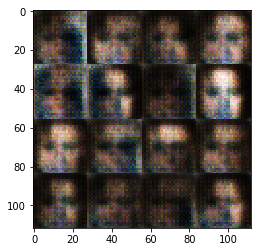

Step 250... Discriminator Loss: 1.5814... Generator Loss: 0.4275
Step 300... Discriminator Loss: 1.2156... Generator Loss: 1.0553
Step 350... Discriminator Loss: 1.4313... Generator Loss: 0.5532
Step 400... Discriminator Loss: 1.4709... Generator Loss: 0.4538


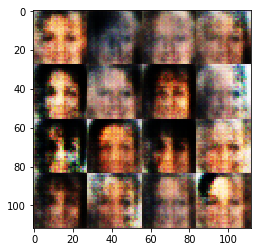

Step 450... Discriminator Loss: 1.3432... Generator Loss: 0.8156
Step 500... Discriminator Loss: 1.6232... Generator Loss: 0.4422
Step 550... Discriminator Loss: 1.2902... Generator Loss: 0.7552
Step 600... Discriminator Loss: 1.5765... Generator Loss: 0.4700


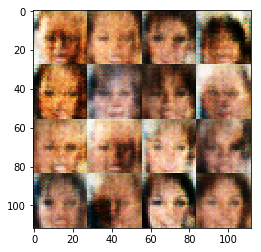

Step 650... Discriminator Loss: 1.5253... Generator Loss: 1.0836
Step 700... Discriminator Loss: 1.3365... Generator Loss: 0.6136
Step 750... Discriminator Loss: 1.4063... Generator Loss: 0.5698
Step 800... Discriminator Loss: 1.5608... Generator Loss: 0.4931


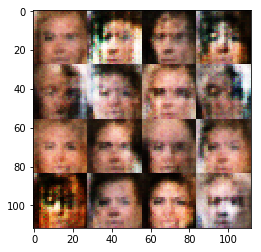

Step 850... Discriminator Loss: 1.4430... Generator Loss: 0.5281
Step 900... Discriminator Loss: 1.4727... Generator Loss: 0.6371
Step 950... Discriminator Loss: 1.2622... Generator Loss: 0.7428
Step 1000... Discriminator Loss: 1.6902... Generator Loss: 1.0218


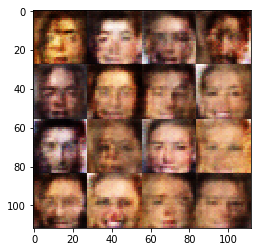

Step 1050... Discriminator Loss: 1.2681... Generator Loss: 0.7981
Step 1100... Discriminator Loss: 1.4249... Generator Loss: 0.7297
Step 1150... Discriminator Loss: 1.5057... Generator Loss: 0.7317
Step 1200... Discriminator Loss: 1.2658... Generator Loss: 0.8835


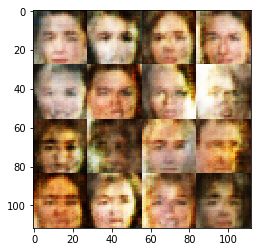

Step 1250... Discriminator Loss: 1.5072... Generator Loss: 0.5448
Step 1300... Discriminator Loss: 1.3889... Generator Loss: 0.6306
Step 1350... Discriminator Loss: 1.3091... Generator Loss: 0.7594
Step 1400... Discriminator Loss: 1.3199... Generator Loss: 0.9033


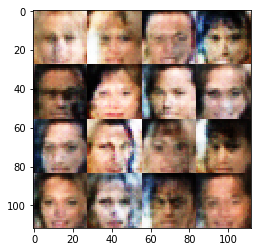

Step 1450... Discriminator Loss: 1.2862... Generator Loss: 0.8500
Step 1500... Discriminator Loss: 1.4102... Generator Loss: 0.6168
Step 1550... Discriminator Loss: 1.3843... Generator Loss: 0.6821
Step 1600... Discriminator Loss: 1.2834... Generator Loss: 0.8477


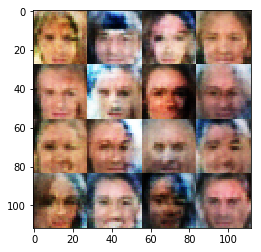

Step 1650... Discriminator Loss: 1.6889... Generator Loss: 0.3563
Step 1700... Discriminator Loss: 1.3347... Generator Loss: 0.8287
Step 1750... Discriminator Loss: 1.2791... Generator Loss: 0.6133
Step 1800... Discriminator Loss: 1.2992... Generator Loss: 0.9188


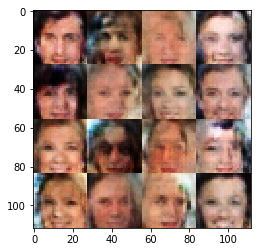

Step 1850... Discriminator Loss: 1.3232... Generator Loss: 0.6898
Step 1900... Discriminator Loss: 1.3126... Generator Loss: 0.7417
Step 1950... Discriminator Loss: 1.5152... Generator Loss: 0.4657
Step 2000... Discriminator Loss: 1.3008... Generator Loss: 1.0073


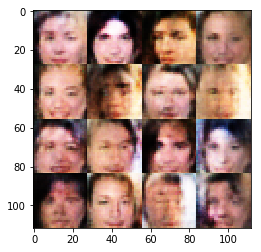

Step 2050... Discriminator Loss: 1.4025... Generator Loss: 0.6240
Step 2100... Discriminator Loss: 1.2588... Generator Loss: 0.7777
Step 2150... Discriminator Loss: 1.3431... Generator Loss: 0.7704
Step 2200... Discriminator Loss: 1.5462... Generator Loss: 0.4533


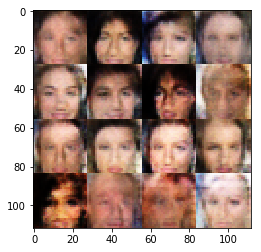

Step 2250... Discriminator Loss: 1.3220... Generator Loss: 0.6090
Step 2300... Discriminator Loss: 1.3951... Generator Loss: 0.6636
Step 2350... Discriminator Loss: 1.3609... Generator Loss: 0.6158
Step 2400... Discriminator Loss: 1.2298... Generator Loss: 0.8613


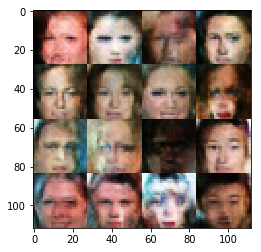

Step 2450... Discriminator Loss: 1.5625... Generator Loss: 0.4875
Step 2500... Discriminator Loss: 1.2357... Generator Loss: 0.8428
Step 2550... Discriminator Loss: 1.2503... Generator Loss: 0.6827
Step 2600... Discriminator Loss: 1.4352... Generator Loss: 0.7936


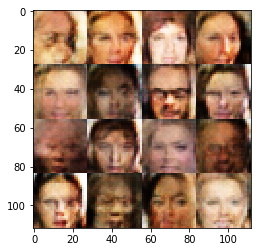

Step 2650... Discriminator Loss: 1.2879... Generator Loss: 0.6871
Step 2700... Discriminator Loss: 1.2268... Generator Loss: 0.7915
Step 2750... Discriminator Loss: 1.5035... Generator Loss: 0.4840
Step 2800... Discriminator Loss: 1.1610... Generator Loss: 0.8261


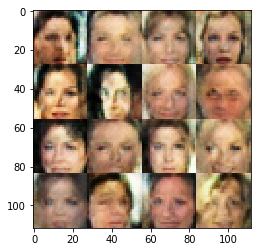

Step 2850... Discriminator Loss: 1.2030... Generator Loss: 0.9102
Step 2900... Discriminator Loss: 1.3122... Generator Loss: 0.6638
Step 2950... Discriminator Loss: 1.4868... Generator Loss: 0.4560
Step 3000... Discriminator Loss: 1.2262... Generator Loss: 0.9293


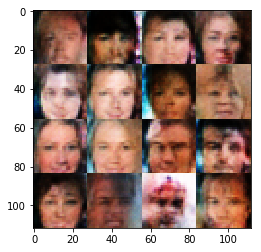

Step 3050... Discriminator Loss: 1.2542... Generator Loss: 0.7561
Step 3100... Discriminator Loss: 1.3572... Generator Loss: 0.7017
Step 3150... Discriminator Loss: 1.4673... Generator Loss: 0.5046
Step 3200... Discriminator Loss: 1.5689... Generator Loss: 0.4266


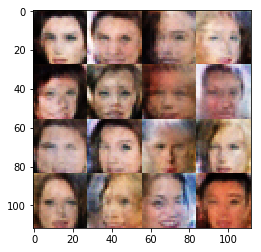

Step 3250... Discriminator Loss: 1.2632... Generator Loss: 0.8267
Step 3300... Discriminator Loss: 1.3990... Generator Loss: 0.5132
Step 3350... Discriminator Loss: 1.5486... Generator Loss: 0.4694
Step 3400... Discriminator Loss: 1.4808... Generator Loss: 0.4322


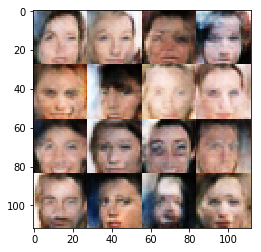

Step 3450... Discriminator Loss: 1.1443... Generator Loss: 1.0707
Step 3500... Discriminator Loss: 1.4280... Generator Loss: 0.5211
Step 3550... Discriminator Loss: 1.1943... Generator Loss: 0.7085
Step 3600... Discriminator Loss: 1.1146... Generator Loss: 0.8780


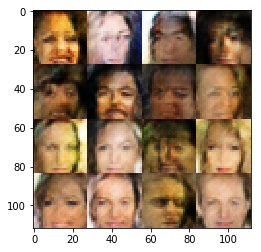

Step 3650... Discriminator Loss: 1.2866... Generator Loss: 0.6419
Step 3700... Discriminator Loss: 1.4720... Generator Loss: 0.4846
Step 3750... Discriminator Loss: 1.2552... Generator Loss: 0.7335
Step 3800... Discriminator Loss: 1.1279... Generator Loss: 0.7662


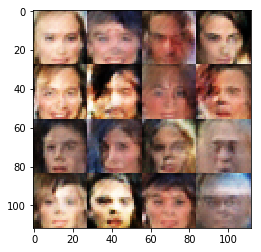

Step 3850... Discriminator Loss: 1.4815... Generator Loss: 0.4827
Step 3900... Discriminator Loss: 1.4428... Generator Loss: 0.5766
Step 3950... Discriminator Loss: 1.2132... Generator Loss: 0.7288
Step 4000... Discriminator Loss: 1.2896... Generator Loss: 0.6458


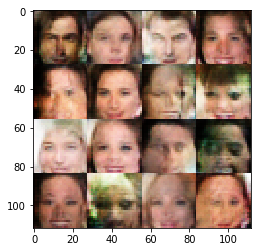

Step 4050... Discriminator Loss: 1.7448... Generator Loss: 0.3218
Step 4100... Discriminator Loss: 1.3222... Generator Loss: 0.6045
Step 4150... Discriminator Loss: 1.5206... Generator Loss: 0.4704
Step 4200... Discriminator Loss: 1.4507... Generator Loss: 0.5506


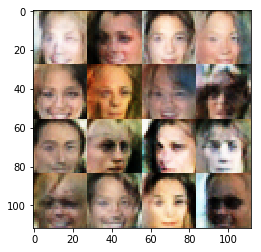

Step 4250... Discriminator Loss: 1.3493... Generator Loss: 0.6445
Step 4300... Discriminator Loss: 1.4999... Generator Loss: 0.5448
Step 4350... Discriminator Loss: 1.3013... Generator Loss: 0.7132
Step 4400... Discriminator Loss: 1.3563... Generator Loss: 0.5532


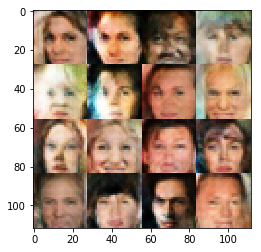

Step 4450... Discriminator Loss: 1.2959... Generator Loss: 0.7689
Step 4500... Discriminator Loss: 1.2310... Generator Loss: 0.6272
Step 4550... Discriminator Loss: 1.2715... Generator Loss: 0.7707
Step 4600... Discriminator Loss: 1.2751... Generator Loss: 0.6546


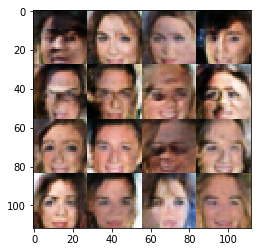

Step 4650... Discriminator Loss: 1.4935... Generator Loss: 0.5005
Step 4700... Discriminator Loss: 1.4677... Generator Loss: 0.5058
Step 4750... Discriminator Loss: 1.4151... Generator Loss: 0.7005
Step 4800... Discriminator Loss: 1.4500... Generator Loss: 0.5047


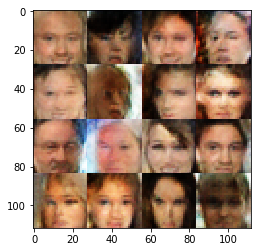

Step 4850... Discriminator Loss: 1.1276... Generator Loss: 0.7614
Step 4900... Discriminator Loss: 1.6603... Generator Loss: 0.3632
Step 4950... Discriminator Loss: 1.3484... Generator Loss: 0.5243
Step 5000... Discriminator Loss: 1.7715... Generator Loss: 0.3191


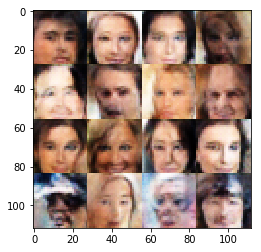

Step 5050... Discriminator Loss: 1.4312... Generator Loss: 0.6857
Step 5100... Discriminator Loss: 1.7586... Generator Loss: 0.3283
Step 5150... Discriminator Loss: 1.3204... Generator Loss: 0.7384
Step 5200... Discriminator Loss: 1.4977... Generator Loss: 0.4748


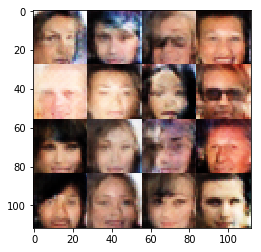

Step 5250... Discriminator Loss: 1.6640... Generator Loss: 0.4487
Step 5300... Discriminator Loss: 1.3711... Generator Loss: 0.8234
Step 5350... Discriminator Loss: 1.2709... Generator Loss: 0.5932
Step 5400... Discriminator Loss: 1.5429... Generator Loss: 0.4302


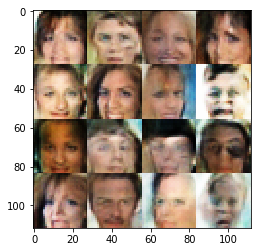

Step 5450... Discriminator Loss: 1.3131... Generator Loss: 0.7511
Step 5500... Discriminator Loss: 1.3472... Generator Loss: 0.7123
Step 5550... Discriminator Loss: 1.5469... Generator Loss: 0.5413
Step 5600... Discriminator Loss: 1.3804... Generator Loss: 0.9911


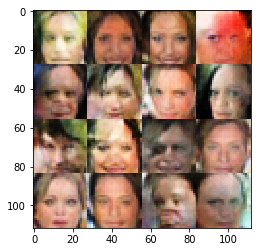

Step 5650... Discriminator Loss: 1.3224... Generator Loss: 0.5532
Step 5700... Discriminator Loss: 1.5161... Generator Loss: 0.4451
Step 5750... Discriminator Loss: 1.4218... Generator Loss: 0.5742
Step 5800... Discriminator Loss: 1.1588... Generator Loss: 0.7733


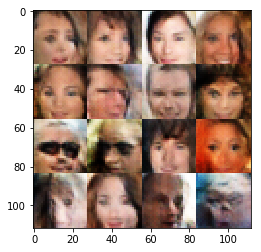

Step 5850... Discriminator Loss: 1.3426... Generator Loss: 0.6746
Step 5900... Discriminator Loss: 1.2383... Generator Loss: 0.6878
Step 5950... Discriminator Loss: 1.3202... Generator Loss: 0.6608
Step 6000... Discriminator Loss: 1.3069... Generator Loss: 0.5958


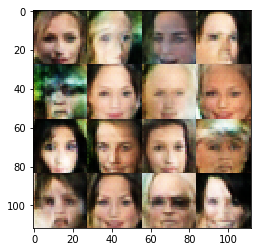

Step 6050... Discriminator Loss: 1.4822... Generator Loss: 0.5500
Step 6100... Discriminator Loss: 1.5828... Generator Loss: 0.5983
Step 6150... Discriminator Loss: 1.7923... Generator Loss: 0.3395
Step 6200... Discriminator Loss: 1.2970... Generator Loss: 0.7793


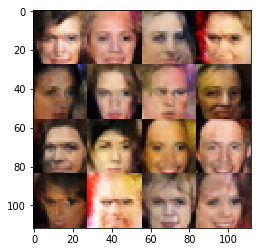

Step 6250... Discriminator Loss: 1.4278... Generator Loss: 0.5564
Step 6300... Discriminator Loss: 1.3749... Generator Loss: 0.8165
Step 6350... Discriminator Loss: 1.5734... Generator Loss: 0.5951
Step 6400... Discriminator Loss: 1.2436... Generator Loss: 0.8639


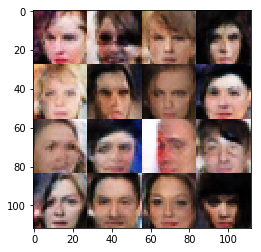

Step 6450... Discriminator Loss: 1.3060... Generator Loss: 0.6919
Step 6500... Discriminator Loss: 1.6405... Generator Loss: 0.4449
Step 6550... Discriminator Loss: 1.5611... Generator Loss: 0.4157
Step 6600... Discriminator Loss: 1.2960... Generator Loss: 0.6618


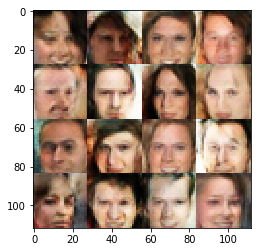

Step 6650... Discriminator Loss: 1.2160... Generator Loss: 0.7181
Step 6700... Discriminator Loss: 1.2548... Generator Loss: 0.8372
Step 6750... Discriminator Loss: 1.2816... Generator Loss: 0.6701
Step 6800... Discriminator Loss: 1.2734... Generator Loss: 0.6593


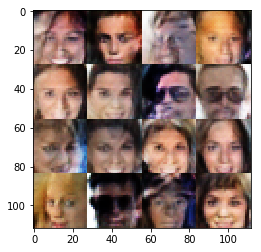

Step 6850... Discriminator Loss: 1.4579... Generator Loss: 0.8149
Step 6900... Discriminator Loss: 1.6719... Generator Loss: 0.3396
Step 6950... Discriminator Loss: 1.1918... Generator Loss: 0.9937
Step 7000... Discriminator Loss: 1.2398... Generator Loss: 0.8000


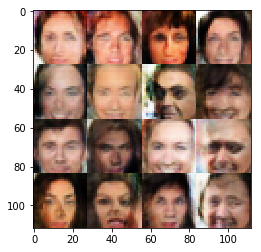

Step 7050... Discriminator Loss: 1.1484... Generator Loss: 1.2195
Step 7100... Discriminator Loss: 1.4199... Generator Loss: 0.5307
Step 7150... Discriminator Loss: 1.5675... Generator Loss: 0.4408
Step 7200... Discriminator Loss: 1.4309... Generator Loss: 0.4841


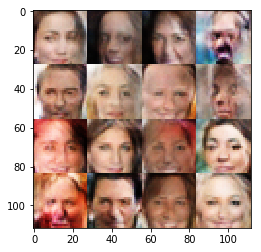

Step 7250... Discriminator Loss: 1.4173... Generator Loss: 0.5190
Step 7300... Discriminator Loss: 1.2546... Generator Loss: 0.6934
Step 7350... Discriminator Loss: 1.3054... Generator Loss: 0.7695
Step 7400... Discriminator Loss: 1.3438... Generator Loss: 0.7583


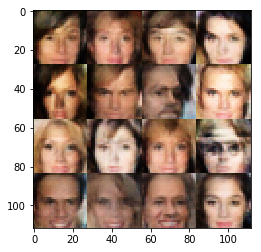

Step 7450... Discriminator Loss: 1.7314... Generator Loss: 0.3299
Step 7500... Discriminator Loss: 1.0826... Generator Loss: 0.8523
Step 7550... Discriminator Loss: 1.5279... Generator Loss: 0.4819
Step 7600... Discriminator Loss: 1.3624... Generator Loss: 0.6410


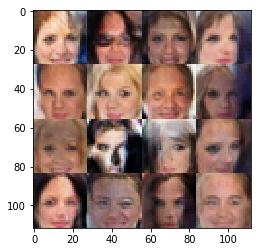

Step 7650... Discriminator Loss: 1.3356... Generator Loss: 0.5854
Step 7700... Discriminator Loss: 1.3606... Generator Loss: 0.6659
Step 7750... Discriminator Loss: 1.5268... Generator Loss: 0.4889
Step 7800... Discriminator Loss: 1.6995... Generator Loss: 0.3608


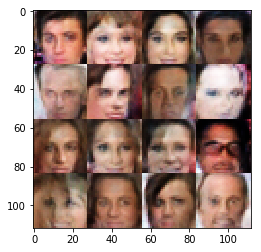

Step 7850... Discriminator Loss: 1.2296... Generator Loss: 0.8092
Step 7900... Discriminator Loss: 1.4925... Generator Loss: 0.4774
Step 7950... Discriminator Loss: 1.3848... Generator Loss: 0.8337
Step 8000... Discriminator Loss: 1.0797... Generator Loss: 0.9021


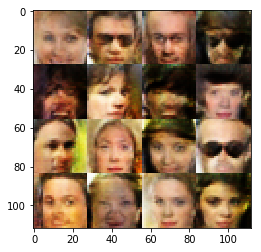

Step 8050... Discriminator Loss: 1.2105... Generator Loss: 0.6990
Step 8100... Discriminator Loss: 1.4374... Generator Loss: 0.5198
Step 8150... Discriminator Loss: 1.2250... Generator Loss: 0.7101
Step 8200... Discriminator Loss: 1.3048... Generator Loss: 0.6966


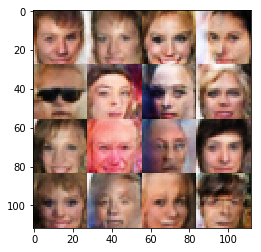

Step 8250... Discriminator Loss: 1.2488... Generator Loss: 0.6930
Step 8300... Discriminator Loss: 1.5823... Generator Loss: 0.4473
Step 8350... Discriminator Loss: 1.2607... Generator Loss: 0.7856
Step 8400... Discriminator Loss: 1.7076... Generator Loss: 0.4768


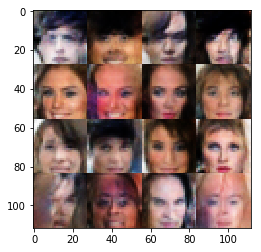

Step 8450... Discriminator Loss: 1.4106... Generator Loss: 0.4995
Step 8500... Discriminator Loss: 1.6807... Generator Loss: 0.3429
Step 8550... Discriminator Loss: 1.1144... Generator Loss: 1.2470
Step 8600... Discriminator Loss: 1.2776... Generator Loss: 0.7079


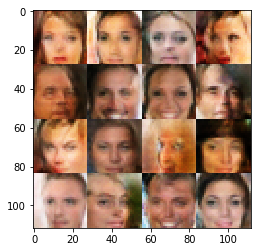

Step 8650... Discriminator Loss: 1.4882... Generator Loss: 0.4968
Step 8700... Discriminator Loss: 1.3585... Generator Loss: 0.6964
Step 8750... Discriminator Loss: 1.7209... Generator Loss: 0.3833
Step 8800... Discriminator Loss: 1.3039... Generator Loss: 0.6355


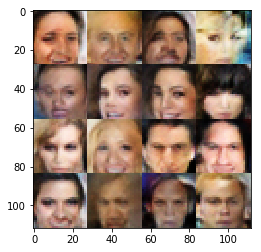

Step 8850... Discriminator Loss: 1.2862... Generator Loss: 0.6362
Step 8900... Discriminator Loss: 1.4061... Generator Loss: 0.7403
Step 8950... Discriminator Loss: 1.4339... Generator Loss: 0.4973
Step 9000... Discriminator Loss: 1.3250... Generator Loss: 0.7051


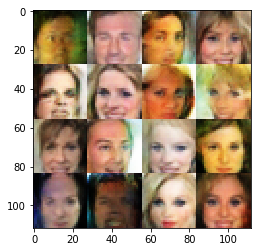

Step 9050... Discriminator Loss: 1.4031... Generator Loss: 0.5312
Step 9100... Discriminator Loss: 1.2259... Generator Loss: 0.7256
Step 9150... Discriminator Loss: 1.3726... Generator Loss: 0.7109
Step 9200... Discriminator Loss: 1.4476... Generator Loss: 0.5793


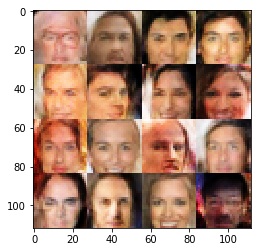

Step 9250... Discriminator Loss: 1.2194... Generator Loss: 0.6658
Step 9300... Discriminator Loss: 1.2829... Generator Loss: 0.7417
Step 9350... Discriminator Loss: 1.1003... Generator Loss: 0.7738
Step 9400... Discriminator Loss: 1.6273... Generator Loss: 0.3543


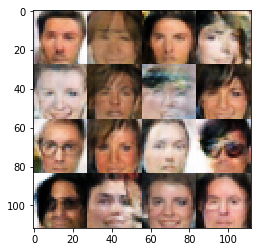

Step 9450... Discriminator Loss: 1.4100... Generator Loss: 0.5620
Step 9500... Discriminator Loss: 1.3456... Generator Loss: 0.5187
Step 9550... Discriminator Loss: 1.3419... Generator Loss: 0.6904
Step 9600... Discriminator Loss: 1.3669... Generator Loss: 0.6343


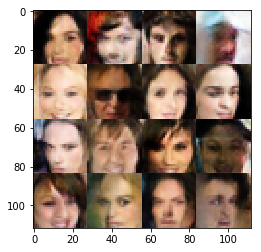

Step 9650... Discriminator Loss: 1.4544... Generator Loss: 0.4536
Step 9700... Discriminator Loss: 0.8726... Generator Loss: 1.1955
Step 9750... Discriminator Loss: 1.4776... Generator Loss: 0.4301
Step 9800... Discriminator Loss: 1.3105... Generator Loss: 0.6219


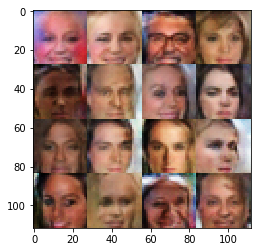

Step 9850... Discriminator Loss: 1.4365... Generator Loss: 0.5015
Step 9900... Discriminator Loss: 1.2076... Generator Loss: 0.6774
Step 9950... Discriminator Loss: 1.3357... Generator Loss: 0.6849
Step 10000... Discriminator Loss: 1.4576... Generator Loss: 0.5772


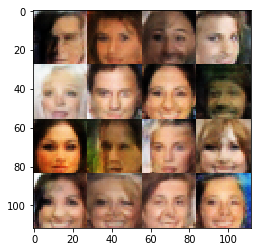

Step 10050... Discriminator Loss: 1.1430... Generator Loss: 0.9608
Step 10100... Discriminator Loss: 1.4008... Generator Loss: 0.5173
Step 10150... Discriminator Loss: 1.2475... Generator Loss: 0.7166
Step 10200... Discriminator Loss: 1.9353... Generator Loss: 0.2468


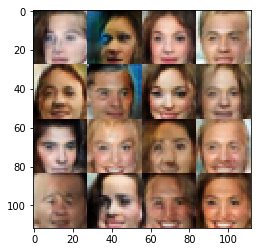

Step 10250... Discriminator Loss: 1.3291... Generator Loss: 1.0002
Step 10300... Discriminator Loss: 1.4594... Generator Loss: 0.4414
Step 10350... Discriminator Loss: 1.4705... Generator Loss: 0.5259
Step 10400... Discriminator Loss: 1.2781... Generator Loss: 0.5979


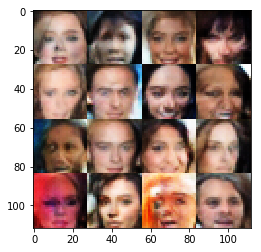

Step 10450... Discriminator Loss: 1.2760... Generator Loss: 0.9115
Step 10500... Discriminator Loss: 1.5268... Generator Loss: 0.6287
Step 10550... Discriminator Loss: 1.4898... Generator Loss: 0.4500
Step 10600... Discriminator Loss: 1.0705... Generator Loss: 0.8534


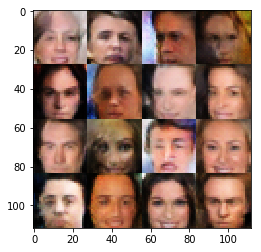

Step 10650... Discriminator Loss: 1.7033... Generator Loss: 0.3944
Step 10700... Discriminator Loss: 1.3682... Generator Loss: 0.5284
Step 10750... Discriminator Loss: 1.6506... Generator Loss: 0.4528
Step 10800... Discriminator Loss: 1.5457... Generator Loss: 0.4807


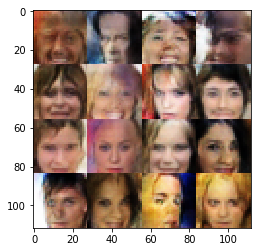

Step 10850... Discriminator Loss: 1.2372... Generator Loss: 0.6518
Step 10900... Discriminator Loss: 1.3167... Generator Loss: 0.7686
Step 10950... Discriminator Loss: 1.3634... Generator Loss: 0.5506
Step 11000... Discriminator Loss: 1.4443... Generator Loss: 0.5059


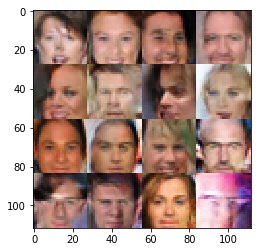

Step 11050... Discriminator Loss: 1.2938... Generator Loss: 0.5838
Step 11100... Discriminator Loss: 1.4127... Generator Loss: 0.5633
Step 11150... Discriminator Loss: 1.2058... Generator Loss: 0.6152
Step 11200... Discriminator Loss: 1.4300... Generator Loss: 0.4654


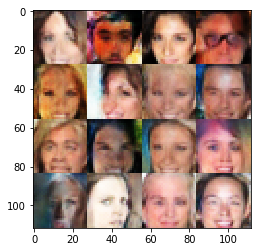

Step 11250... Discriminator Loss: 1.2619... Generator Loss: 0.6367
Step 11300... Discriminator Loss: 1.6232... Generator Loss: 0.4462
Step 11350... Discriminator Loss: 1.7095... Generator Loss: 0.3757
Step 11400... Discriminator Loss: 1.4202... Generator Loss: 0.5163


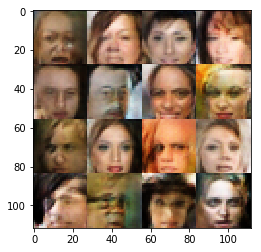

Step 11450... Discriminator Loss: 1.6960... Generator Loss: 0.3357
Step 11500... Discriminator Loss: 1.4133... Generator Loss: 0.5194
Step 11550... Discriminator Loss: 1.3219... Generator Loss: 0.6556
Step 11600... Discriminator Loss: 1.4763... Generator Loss: 0.5124


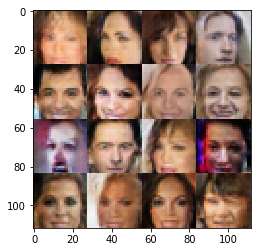

Step 11650... Discriminator Loss: 1.3806... Generator Loss: 0.6585
Step 11700... Discriminator Loss: 1.2318... Generator Loss: 0.6739
Step 11750... Discriminator Loss: 1.4224... Generator Loss: 0.5653
Step 11800... Discriminator Loss: 1.1914... Generator Loss: 0.7322


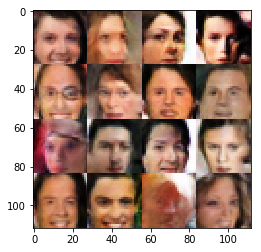

Step 11850... Discriminator Loss: 1.3118... Generator Loss: 0.5736
Step 11900... Discriminator Loss: 1.3051... Generator Loss: 0.6743
Step 11950... Discriminator Loss: 1.4376... Generator Loss: 0.5073
Step 12000... Discriminator Loss: 1.3043... Generator Loss: 0.6343


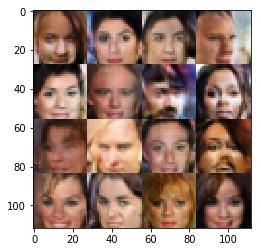

Step 12050... Discriminator Loss: 1.4250... Generator Loss: 0.4963
Step 12100... Discriminator Loss: 1.3312... Generator Loss: 0.5411
Step 12150... Discriminator Loss: 1.2288... Generator Loss: 0.7192
Step 12200... Discriminator Loss: 1.2097... Generator Loss: 0.8155


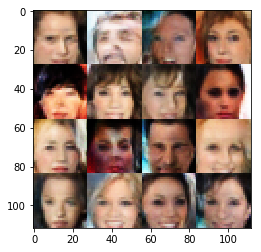

Step 12250... Discriminator Loss: 1.4220... Generator Loss: 0.4459
Step 12300... Discriminator Loss: 1.3370... Generator Loss: 0.6798
Step 12350... Discriminator Loss: 1.2662... Generator Loss: 1.2411
Step 12400... Discriminator Loss: 1.1133... Generator Loss: 0.8066


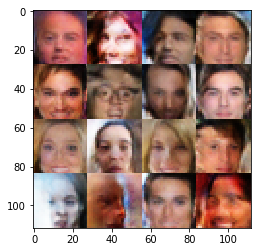

Step 12450... Discriminator Loss: 1.5114... Generator Loss: 0.4807
Step 12500... Discriminator Loss: 1.2718... Generator Loss: 0.5615
Step 12550... Discriminator Loss: 1.2181... Generator Loss: 0.6512
Step 12600... Discriminator Loss: 1.0671... Generator Loss: 0.8448


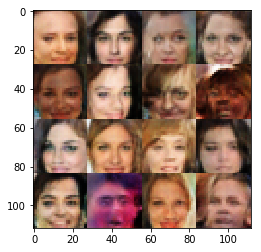

Step 12650... Discriminator Loss: 1.4731... Generator Loss: 0.4739


In [17]:
# with Smooth = 0.1
batch_size = 16
z_dim = 128
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.